## Global settings and imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt
import optuna
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
import torch
from torch.utils.data import DataLoader

import os

from evaluation import MetricEvaluator, AucScore, NdcgScore, MrrScore

from utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
    DEFAULT_SUBTITLE_COL,
    DEFAULT_TITLE_COL,
    DEFAULT_USER_COL,
)
from utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from utils._polars import slice_join_dataframes
from utils._articles import create_article_id_to_value_mapping
from utils._nlp import generate_embeddings_with_transformers
from utils._constants import DEFAULT_HISTORY_IMPRESSION_TIMESTAMP_COL, DEFAULT_IMPRESSION_TIMESTAMP_COL
from utils._python import batch_items_generator

from models_pytorch.NRMSDocVecModel import NRMSDocVecModel
from models_pytorch.dataloader import NRMSDataSet
from models_pytorch.model_config import hparams_nrms_torch

# Check Python version
print(f"Python version: {sys.version.split()[0]}")

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU device: {torch.cuda.get_device_name()}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")

/home/miki/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Python version: 3.10.12
PyTorch version: 2.4.1+cu124
CUDA available: True
Current GPU device: NVIDIA GeForce RTX 3060 Laptop GPU
Number of GPUs available: 1


## Prepare parameters

In [2]:
seed = 42
batch_size = 64

# Options: demo, small, large
MIND_type = 'demo'

## Looking at behaviours and history

## Download and load data

In [3]:
DATASPLIT = "ebnerd_small"
PATH = Path(f"./{DATASPLIT}")  # Base path for your data directory
print(PATH)

ebnerd_small


In [4]:
def ebnerd_from_path(path: Path, history_size: int = 30) -> pl.DataFrame:
    """
    Load ebnerd - function
    """
    df_history = (
        pl.scan_parquet(path.joinpath("history.parquet"))
        .select([
            DEFAULT_USER_COL, 
            DEFAULT_HISTORY_ARTICLE_ID_COL,
            DEFAULT_HISTORY_IMPRESSION_TIMESTAMP_COL
        ])
        .pipe(
            truncate_history,
            column=DEFAULT_HISTORY_ARTICLE_ID_COL,
            history_size=history_size,
            enable_warning=False,
        )
        .pipe(
            truncate_history,
            column=DEFAULT_HISTORY_IMPRESSION_TIMESTAMP_COL,
            history_size=history_size,
            enable_warning=False,
        )
    )
    df_behaviors = (
        pl.scan_parquet(path.joinpath("behaviors.parquet"))
        .collect()
        .pipe(
            slice_join_dataframes,
            df2=df_history.collect(),
            on=DEFAULT_USER_COL,
            how="left",
        )
    )
    return df_behaviors

COLUMNS = [
    DEFAULT_USER_COL,
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
    DEFAULT_IMPRESSION_TIMESTAMP_COL,
    DEFAULT_HISTORY_IMPRESSION_TIMESTAMP_COL
]
HISTORY_SIZE = hparams_nrms_torch.__dict__['history_size']
FRACTION = 0.5

df_train = (
    ebnerd_from_path(PATH.joinpath("train"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(
        sampling_strategy_wu2019,
        npratio=4,
        shuffle=True,
        with_replacement=True,
        seed=123,
    )
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
# =>
df_validation = (
    ebnerd_from_path(PATH.joinpath("validation"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
df_train.head(2)

user_id,article_id_fixed,article_ids_inview,article_ids_clicked,impression_id,impression_time,impression_time_fixed,labels
u32,list[i32],list[i64],list[i64],u32,datetime[μs],list[datetime[μs]],list[i8]
2406042,"[9759345, 9184908, … 9767363]","[9773962, 9193263, … 9774013]",[9773962],34447285,2023-05-20 21:25:04,"[2023-05-15 18:03:21, 2023-05-15 18:03:55, … 2023-05-17 19:48:06]","[1, 0, … 0]"
1119007,"[9741124, 9740612, … 9762145]","[9775785, 9575236, … 9575236]",[9775881],10730680,2023-05-22 14:27:48,"[2023-04-28 16:08:39, 2023-04-28 16:09:52, … 2023-05-12 15:26:23]","[0, 0, … 0]"


/tmp/ipykernel_22241/1133741487.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_validation_filtered = df_validation.filter(


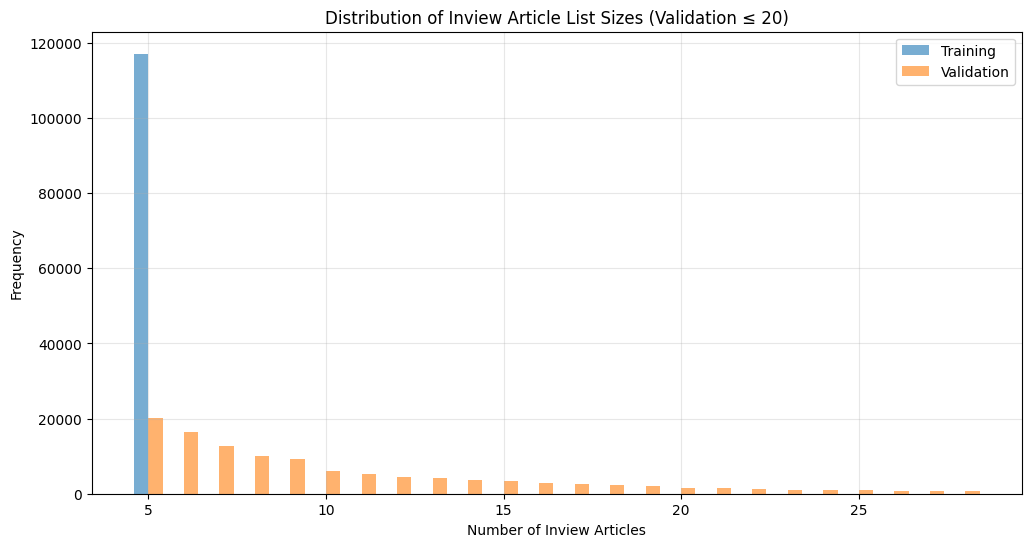

Validation dataset sizes:
Original: 122323 records
Filtered: 115183 records
Removed: 7140 records

Training Data Statistics:
Mean: 5.00
Median: 5.00
Min: 5
Max: 5

Filtered Validation Data Statistics:
Mean: 10.21
Median: 8.00
Min: 5
Max: 28


In [5]:
# Filter validation data
df_validation_filtered = df_validation.filter(
    pl.col(DEFAULT_INVIEW_ARTICLES_COL).map_elements(lambda x: len(x) <= 28)
)

# Calculate distributions
train_lengths = [len(row) for row in df_train[DEFAULT_INVIEW_ARTICLES_COL]]
valid_lengths = [len(row) for row in df_validation_filtered[DEFAULT_INVIEW_ARTICLES_COL]]

# Create visualization
plt.figure(figsize=(12, 6))
plt.bar(pd.Series(train_lengths).value_counts().sort_index().index - 0.2, 
        pd.Series(train_lengths).value_counts().sort_index().values, 
        width=0.4, label='Training', alpha=0.6)
plt.bar(pd.Series(valid_lengths).value_counts().sort_index().index + 0.2, 
        pd.Series(valid_lengths).value_counts().sort_index().values, 
        width=0.4, label='Validation', alpha=0.6)

plt.xlabel('Number of Inview Articles')
plt.ylabel('Frequency')
plt.title('Distribution of Inview Article List Sizes (Validation ≤ 20)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print("Validation dataset sizes:")
print(f"Original: {len(df_validation)} records")
print(f"Filtered: {len(df_validation_filtered)} records")
print(f"Removed: {len(df_validation) - len(df_validation_filtered)} records")

print("\nTraining Data Statistics:")
print(f"Mean: {np.mean(train_lengths):.2f}")
print(f"Median: {np.median(train_lengths):.2f}")
print(f"Min: {min(train_lengths)}")
print(f"Max: {max(train_lengths)}")

print("\nFiltered Validation Data Statistics:")
print(f"Mean: {np.mean(valid_lengths):.2f}")
print(f"Median: {np.median(valid_lengths):.2f}")
print(f"Min: {min(valid_lengths)}")
print(f"Max: {max(valid_lengths)}")

In [6]:
def calculate_average_length(df, column):
    total_length = sum(len(row) for row in df[column])
    average_length = total_length / len(df)
    return average_length

# Calculate average length for df_train
average_length_inview_train = calculate_average_length(df_train, DEFAULT_INVIEW_ARTICLES_COL)
print(f"Average length of article_ids_inview in df_train: {average_length_inview_train}")

# Calculate average length for df_validation
average_length_inview_validation = calculate_average_length(df_validation, DEFAULT_INVIEW_ARTICLES_COL)
print(f"Average length of article_ids_inview in df_validation: {average_length_inview_validation}")

Average length of article_ids_inview in df_train: 5.0
Average length of article_ids_inview in df_validation: 11.971534380288253


In [7]:
# Function to find the maximum length of arrays in a column
def find_max_length(df, column):
    max_length = 0
    for row in df[column]:
        max_length = max(max_length, len(row))
    return max_length

# Find the longest inview article length in df_train
max_inview_length_train = find_max_length(df_train, DEFAULT_INVIEW_ARTICLES_COL)

# Find the longest inview article length in df_validation
max_inview_length_validation = find_max_length(df_validation, DEFAULT_INVIEW_ARTICLES_COL)

print(f"Longest inview article length in df_train: {max_inview_length_train}")
print(f"Longest inview article length in df_validation: {max_inview_length_validation}")

max_history_length_train = find_max_length(df_train, DEFAULT_HISTORY_ARTICLE_ID_COL)
max_history_length_validation = find_max_length(df_validation, DEFAULT_HISTORY_ARTICLE_ID_COL)

print(f"Longest history length in df_train: {max_history_length_train}")
print(f"Longest history length in df_validation: {max_history_length_validation}")

Longest inview article length in df_train: 5
Longest inview article length in df_validation: 99
Longest history length in df_train: 50
Longest history length in df_validation: 50


In [8]:
# Function to filter rows with exactly one clicked article
def filter_rows_with_one_clicked_article(df, clicked_articles_col):
    # Manually filter rows where the array has exactly one element
    filtered_rows = []
    for row in df.iter_rows(named=True):
        if len(row[clicked_articles_col]) == 1:
            filtered_rows.append(row)
    return pl.DataFrame(filtered_rows)


# Filter rows in df_train and df_validation
df_train = filter_rows_with_one_clicked_article(df_train, DEFAULT_CLICKED_ARTICLES_COL)
df_validation = filter_rows_with_one_clicked_article(df_validation, DEFAULT_CLICKED_ARTICLES_COL)

# Print the results
print(f"Number of rows with exactly one clicked article in df_train: {df_train.shape[0]}")
print(f"Number of rows with exactly one clicked article in df_validation: {df_validation.shape[0]}")


Number of rows with exactly one clicked article in df_train: 117138
Number of rows with exactly one clicked article in df_validation: 121634


## Embedding tokenized article title

In [9]:
# Load the document vector parquet file
document_vector_path = Path("Ekstra_Bladet_word2vec/document_vector.parquet")
df_document_vector = pl.read_parquet(document_vector_path)

## Reduce dimensionality of embeddings

In [10]:
def reduce_and_analyze_dimensionality(embeddings_array, target_dims=[24, 32, 64, 128, 150, 200, 256]):
    """
    Reduce dimensionality using different methods and analyze information retention
    """
    results = {}
    
    # PCA Analysis for different dimensions
    for dim in target_dims:
        # PCA
        pca = PCA(n_components=dim)
        reduced_data_pca = pca.fit_transform(embeddings_array)
        
        # Calculate explained variance ratio
        explained_var = np.sum(pca.explained_variance_ratio_) * 100
        
        results[dim] = {
            'method': 'PCA',
            'explained_variance_ratio': explained_var,
            'reduced_data': reduced_data_pca
        }
        
        print(f"\nDimensionality Reduction to {dim} dimensions:")
        print(f"Explained variance ratio (PCA): {explained_var:.2f}%")
        print(f"Shape after reduction: {reduced_data_pca.shape}")

    return results

# Convert document vectors to numpy array
vectors = np.stack(df_document_vector['document_vector'].to_list())
print("Original vector shape:", vectors.shape)

# Analyze different dimensionality reductions
reduction_results = reduce_and_analyze_dimensionality(vectors)

# Based on the analysis results, choose your preferred dimension
# For example, if you want 90% variance explained while minimizing dimensions:
chosen_dim = hparams_nrms_torch.__dict__['embedding_dim']

print(f"\nChosen dimension: {chosen_dim}")
print(f"Explained variance ratio: {reduction_results[chosen_dim]['explained_variance_ratio']:.2f}%")

# Reduce to chosen dimension
pca = PCA(n_components=chosen_dim)
reduced_vectors = pca.fit_transform(vectors)

# Update DataFrame with reduced vectors
df_document_vector = df_document_vector.with_columns(
    pl.Series('document_vector', reduced_vectors.tolist())
)

# Create new mapping with reduced vectors
article_mapping = create_article_id_to_value_mapping(
    df=df_document_vector,
    value_col='document_vector'
)

Original vector shape: (125541, 300)

Dimensionality Reduction to 24 dimensions:
Explained variance ratio (PCA): 62.99%
Shape after reduction: (125541, 24)

Dimensionality Reduction to 32 dimensions:
Explained variance ratio (PCA): 67.51%
Shape after reduction: (125541, 32)

Dimensionality Reduction to 64 dimensions:
Explained variance ratio (PCA): 78.02%
Shape after reduction: (125541, 64)

Dimensionality Reduction to 128 dimensions:
Explained variance ratio (PCA): 88.32%
Shape after reduction: (125541, 128)

Dimensionality Reduction to 150 dimensions:
Explained variance ratio (PCA): 90.72%
Shape after reduction: (125541, 150)

Dimensionality Reduction to 200 dimensions:
Explained variance ratio (PCA): 94.98%
Shape after reduction: (125541, 200)

Dimensionality Reduction to 256 dimensions:
Explained variance ratio (PCA): 98.40%
Shape after reduction: (125541, 256)

Chosen dimension: 150
Explained variance ratio: 90.72%


# Init dataloaders



In [11]:
train_dataset = NRMSDataSet(
    behaviors=df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    eval_mode=False,
)

val_dataset = NRMSDataSet(
    behaviors=df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    eval_mode=True,
)

Starting preprocessing...
Preprocessing data...
(117138, 8)
Data preprocessing completed in 35.35 seconds.
Starting preprocessing...
Preprocessing data...
(121634, 8)
Data preprocessing completed in 39.98 seconds.


In [12]:
def collate_fn_with_global_padding(batch, max_len_pred, apply_padding_to_targets=True):
    try:
        his_input_titles = [item[0][0] for item in batch]
        his_timestamps = [item[0][1] for item in batch]
        pred_input_titles = [item[0][2] for item in batch]
        batch_ys = [item[1] for item in batch]
        impression_id = torch.tensor([item[2] for item in batch], dtype=torch.int64)

        # Pad sequences
        his_input_titles_padded = pad_sequence(his_input_titles, batch_first=True, padding_value=0)
        his_timestamps_padded = pad_sequence(his_timestamps, batch_first=True, padding_value=0)
        pred_input_titles_padded = pad_sequence(pred_input_titles, batch_first=True, padding_value=0)
        
        if pred_input_titles_padded.size(1) < max_len_pred:
            pad_size = max_len_pred - pred_input_titles_padded.size(1)
            pred_input_titles_padded = torch.nn.functional.pad(
                pred_input_titles_padded, (0, 0, 0, pad_size), value=0
            )
        elif pred_input_titles_padded.size(1) > max_len_pred:
            pred_input_titles_padded = pred_input_titles_padded[:, :max_len_pred, :]

        if apply_padding_to_targets:
            batch_ys_padded = pad_sequence(batch_ys, batch_first=True, padding_value=-1)
            if batch_ys_padded.size(1) < max_len_pred:
                pad_size = max_len_pred - batch_ys_padded.size(1)
                batch_ys_padded = torch.nn.functional.pad(
                    batch_ys_padded, (0, pad_size), value=-1
                )
            elif batch_ys_padded.size(1) > max_len_pred:
                batch_ys_padded = batch_ys_padded[:, :max_len_pred]
            return (his_input_titles_padded, his_timestamps_padded, pred_input_titles_padded), batch_ys_padded, impression_id
        else:
            return (his_input_titles_padded, his_timestamps_padded, pred_input_titles_padded), batch_ys, impression_id
    except Exception as e:
        print(f"Error in collate_fn: {e}")
        raise


In [13]:
# Wrap the dataset with DataLoader
train_dataloader_temp = DataLoader(
    train_dataset,
    batch_size=64,    # Set your desired batch size
    shuffle=True,
    num_workers=0,
    collate_fn=lambda batch: collate_fn_with_global_padding(batch, max_inview_length_validation)
)

val_dataloader_temp = DataLoader(
    val_dataset,
    batch_size=64,    # Set your desired batch size
    shuffle=False,
    num_workers=0,
    collate_fn=lambda batch: collate_fn_with_global_padding(batch, max_inview_length_validation)
)

In [14]:
for batch in val_dataloader_temp:
    (his_input_titles_padded, time_stamps, pred_input_titles_padded), batch_ys_padded, impression_id = batch
    print(his_input_titles_padded[0])  # Look at one padded sequence
    print(time_stamps[0])  # Look at one padded sequence
    print(pred_input_titles_padded[0])  # Look at one padded sequence
    print(batch_ys_padded[0])  # Look at one padded sequence

    print("Batch loaded successfully!")
    break

for batch in train_dataloader_temp:
    (his_input_titles_padded, time_stamps, pred_input_titles_padded), batch_ys_padded, impression_id = batch
    print(pred_input_titles_padded.shape)  # Look at one padded sequence
    print(batch_ys_padded.shape)  # Look at one padded sequence
    print(impression_id)

    print("Batch loaded successfully!")
    break


tensor([[ 0.0052,  0.1612,  0.1213,  ...,  0.0156,  0.0043, -0.0207],
        [ 0.1284, -0.0301, -0.3351,  ...,  0.0027,  0.0009,  0.0068],
        [ 0.1284, -0.0301, -0.3351,  ...,  0.0027,  0.0009,  0.0068],
        ...,
        [-0.0529,  0.1543,  0.1461,  ..., -0.0147,  0.0043,  0.0010],
        [ 0.0562, -0.1907, -0.1243,  ...,  0.0107, -0.0126, -0.0127],
        [-0.0529,  0.1543,  0.1461,  ..., -0.0147,  0.0043,  0.0010]])
tensor([687360., 687360., 621952., 621952., 621952., 621824., 621568., 621568.,
        621568., 621440., 621440., 621312., 621312., 621312., 621184., 621184.,
        605440., 605440., 605440., 605440., 605312., 605184., 605184., 605056.,
        605056., 605056., 605056., 605056., 605056., 605056., 604928., 604928.,
        604928., 604800., 604800., 604800., 604800., 561664., 487424., 487424.,
        487424., 487424., 487424., 487296., 487168., 487040., 487040., 486912.,
        486912., 486784.])
tensor([[ 1.3786e-01, -1.5155e-02, -1.7524e-01,  ...,  3.63

## Create the NRMS model

In [15]:

# Define paths
MODEL_NAME = "NRMS"
LOG_DIR = os.path.join("downloads", "runs", MODEL_NAME)
MODEL_WEIGHTS = os.path.join("downloads", "data", "state_dict", MODEL_NAME, "weights.pth")

# Create directories if they don't exist
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MODEL_WEIGHTS), exist_ok=True)

# Define ModelCheckpoint class
class ModelCheckpoint:
    """Saves the model after every epoch if it has the best performance so far."""
    def __init__(self, filepath, verbose=False, save_best_only=True):
        """
        Args:
            filepath (str): Path to save the model checkpoint.
            verbose (bool): If True, prints a message when the model is saved.
            save_best_only (bool): If True, saves only when the model is better than before.
        """
        self.filepath = filepath
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best_loss = None

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.save_checkpoint(model)

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.filepath)
        if self.verbose:
            print(f"Model saved to {self.filepath}")

# Define EarlyStopping class
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve by a given percentage over a patience period."""
    def __init__(self, patience=3, min_delta=0.05, verbose=False):
        """
        Args:
            patience (int): Number of epochs to wait after last time validation loss improved by min_delta.
            min_delta (float): Minimum percentage improvement required to reset patience.
            verbose (bool): If True, prints a message when early stopping is triggered.
        """
        self.patience = patience
        self.min_delta = min_delta  # Minimum percentage improvement
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            # Initialize best_loss with the first validation loss
            self.best_loss = val_loss
            self.counter = 0
        elif val_loss < self.best_loss * (1 - self.min_delta):
            # Significant improvement found
            self.best_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f"Validation loss improved by at least {self.min_delta*100:.1f}%")
        else:
            # No significant improvement
            self.counter += 1
            if self.verbose:
                print(f"No significant improvement in validation loss. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

## Hyperoptimization

In [16]:
# NUM_EPOCHS = 100

# def objective(trial):
#     # Small search space for head_num and head_dim
#     head_num = trial.suggest_categorical('head_num', [8, 16, 32])
#     head_dim = trial.suggest_categorical('head_dim', [16, 32, 48, 64])
    
#     base_dim = head_num * head_dim
    
#     # attention_hidden_dim equals base_dim for simplicity
#     attention_hidden_dim = base_dim
    
#     # units_per_layer chosen from [128, 256, 512]
#     # One possible interpretation: choose each layer size from this set.
#     units_per_layer = [
#         trial.suggest_categorical(f'unit_layer_{i}', [128, 256, 512]) 
#         for i in range(3)
#     ]
    
#     # Dropout discrete steps: [0.1, 0.2, 0.3, 0.4, 0.5]
#     dropout = trial.suggest_categorical('dropout', [0.1, 0.2, 0.3, 0.4, 0.5])
    
#     # Learning rate: {1e-3, 1e-4, 1e-5}
#     learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-4, 1e-5])
    
#     # Weight decay: {1e-3, 1e-4}
#     weight_decay = trial.suggest_categorical('weight_decay', [1e-3, 1e-4])
    
#     hparams_optimize = {
#         'head_num': head_num,
#         'head_dim': head_dim,
#         'attention_hidden_dim': attention_hidden_dim,
#         'embedding_dim': 24,  # Assume fixed embedding dimension
#         'dropout': dropout,
#         'learning_rate': learning_rate,
#         'news_output_dim': base_dim,
#         'units_per_layer': units_per_layer,
#         'weight_decay': weight_decay,
#         'history_size': 50,  # can be fixed or chosen from a small set if desired
#     }

#     # Initialize model and training components
#     model = NRMSDocVecModel(hparams=hparams_optimize, device=device)
#     criterion = model.get_loss().to(device)
#     optimizer = optim.Adam(
#         model.parameters(), 
#         lr=hparams_optimize['learning_rate'], 
#         weight_decay=hparams_optimize['weight_decay']
#     )
    
#     early_stopping = EarlyStopping(patience=5, min_delta=0.03, verbose=True)
#     best_val_loss = float('inf')

#     for epoch in range(NUM_EPOCHS):
#         model.train()
#         train_loss = train_one_epoch(model, train_dataloader_temp, optimizer, criterion)
        
#         model.eval()
#         val_loss = validate(model, val_dataloader_temp, criterion)
        
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss

#         early_stopping(val_loss)
#         if early_stopping.early_stop:
#             print(f"Early stopping triggered at epoch {epoch}")
#             break

#         trial.report(val_loss, epoch)
#         if trial.should_prune():
#             raise optuna.TrialPruned()

#     return best_val_loss



# def train_one_epoch(model, dataloader, optimizer, criterion):
#     running_loss = 0.0
#     batch_count = 0
    
#     for inputs, targets, impression_ids in dataloader:
#         inputs = [inp.to(device) for inp in inputs]
#         targets = targets.to(device)
#         positive_indices = (targets == 1).nonzero(as_tuple=False)
#         targets = positive_indices[:, 1].long()
        
#         optimizer.zero_grad()
#         outputs = model(*inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         batch_count += 1
    
#     return running_loss / batch_count

# def validate(model, dataloader, criterion):
#     model.eval()
#     val_loss = 0.0
#     batch_count = 0
    
#     with torch.no_grad():
#         for inputs, targets, impression_ids in dataloader:
#             inputs = [inp.to(device) for inp in inputs]
#             targets = targets.to(device)
#             positive_indices = (targets == 1).nonzero(as_tuple=False)
#             targets = positive_indices[:, 1].long()
#             outputs = model(*inputs)
#             loss = criterion(outputs, targets)
#             val_loss += loss.item()
#             batch_count += 1
    
#     return val_loss / batch_count

# # Create study and optimize
# study = optuna.create_study(direction='minimize')
# try:
#     study.optimize(objective, n_trials=50)  # Run 50 trials
# except (KeyboardInterrupt, Exception) as e:
#     print(f"\nOptimization stopped: {e}")

# # Print results of best trial even if interrupted
# if study.trials:  # Check if we have any completed trials
#     print("\nBest trial so far:")
#     trial = study.best_trial
#     print("  Value: ", trial.value)
#     print("  Params: ")
#     for key, value in trial.params.items():
#         print(f"    {key}: {value}")
# else:
#     print("No trials were completed before interruption")

## Train the NRMS model

In [17]:
# Initialize callbacks
model_checkpoint = ModelCheckpoint(filepath=MODEL_WEIGHTS, verbose=True, save_best_only=True)
# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=3, min_delta=0.02, verbose=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")

model = NRMSDocVecModel(hparams=hparams_nrms_torch.__dict__,
                        device=device)
print(f"Model device: {next(model.parameters()).device}")

NUM_EPOCHS = 30

# Define loss function and optimizer
criterion = model.get_loss().to(device)
optimizer = model.get_optimizer(hparams_nrms=hparams_nrms_torch)

# Training parameters
train_losses, val_losses = [], []

# Epoch progress bar
epoch_pbar = tqdm(range(1, NUM_EPOCHS + 1), desc="Training Progress", dynamic_ncols=True)
for epoch in epoch_pbar:
    # Training phase
    model.train()
    running_loss = 0.0
    train_batch_count = 0

    for batch_idx, (inputs, targets, impression_ids) in enumerate(train_dataloader_temp):
        # Prepare data
        inputs = [inp.to(device) for inp in inputs]
        targets = targets.to(device)

        # Get positive labels
        positive_indices = (targets == 1).nonzero(as_tuple=False)
        targets = positive_indices[:, 1].long()

        # Forward and backward passes
        optimizer.zero_grad()
        outputs = model(*inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Update running statistics
        running_loss += loss.item()
        train_batch_count += 1

    # Compute average training loss
    avg_train_loss = running_loss / train_batch_count if train_batch_count > 0 else float('inf')
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_batch_count = 0
    with torch.no_grad():
        for inputs, targets, impression_ids in val_dataloader_temp:
            inputs = [inp.to(device) for inp in inputs]
            targets = targets.to(device)
            positive_indices = (targets == 1).nonzero(as_tuple=False)
            targets = positive_indices[:, 1].long()
            outputs = model(*inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            val_batch_count += 1

    avg_val_loss = val_loss / val_batch_count if val_batch_count > 0 else float('inf')
    val_losses.append(avg_val_loss)

    # Update epoch progress bar with metrics
    epoch_pbar.set_postfix({
        'train_loss': f'{avg_train_loss:.4f}',
        'val_loss': f'{avg_val_loss:.4f}',
    })

    # Save checkpoint
    if epoch % 10 == 0:
        model_checkpoint(model, avg_val_loss)

    # Check early stopping condition
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break  # Exit the training loop


Using device: cuda
Model device: cuda:0
learning rate:  0.0001


/home/miki/Study/2_second/deep learning/Deeplearning-RecSys-Challenge-2024/models_pytorch/NRMSDocVecModel.py:181: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = amp.GradScaler()
Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]/home/miki/Study/2_second/deep learning/Deeplearning-RecSys-Challenge-2024/models_pytorch/NRMSDocVecModel.py:190: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Training Progress:   7%|▋         | 2/30 [02:00<28:09, 60.34s/it, train_loss=1.4186, val_loss=2.2991]

No significant improvement in validation loss. Counter: 1/3


Training Progress:  10%|█         | 3/30 [03:01<27:22, 60.83s/it, train_loss=1.3861, val_loss=2.2891]

No significant improvement in validation loss. Counter: 2/3


Training Progress:  10%|█         | 3/30 [04:02<36:21, 80.80s/it, train_loss=1.3654, val_loss=2.2637]

No significant improvement in validation loss. Counter: 3/3
Early stopping triggered. Stopping training.


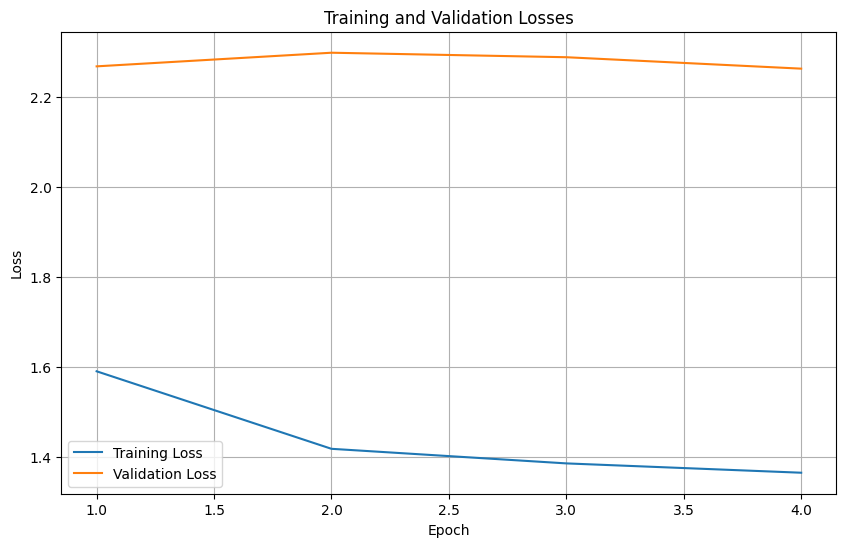


Training Summary:
Initial Training Loss: 1.5909
Final Training Loss: 1.3654
Best Training Loss: 1.3654

Initial Validation Loss: 2.2688
Final Validation Loss: 2.2637
Best Validation Loss: 2.2637


In [18]:
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

# Print final statistics
print("\nTraining Summary:")
print(f"Initial Training Loss: {train_losses[0]:.4f}")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Best Training Loss: {min(train_losses):.4f}")
print(f"\nInitial Validation Loss: {val_losses[0]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation Loss: {min(val_losses):.4f}")

## Evaluate the model

In [19]:
def evaluate_model(model, dataloader, device):
    """Evaluate the model and return predictions and labels for metric calculation."""
    model.eval()
    all_predictions = []
    all_labels = []

    print("\nEvaluating DataLoader...")
    total_samples = len(dataloader.dataset)
    print(f"Total samples in DataLoader: {total_samples}")

    with torch.no_grad():
        for batch_idx, (inputs, targets, impression_ids) in enumerate(dataloader):
            his_input_title, his_input_time, pred_input_title = inputs

            if batch_idx == 0:  # Debug first batch shapes
                print("\nFirst batch shapes:")
                print(f"  - his_input_title: {his_input_title.shape}")
                print(f"  - pred_input_title: {pred_input_title.shape}")
                print(f"  - targets: {targets.shape}")

            # Move data to device
            his_input_title = his_input_title.to(device)
            his_input_time = his_input_time.to(device)
            pred_input_title = pred_input_title.to(device)
            targets = targets.to(device)

            # Get predictions
            predictions = model.predict(his_input_title, his_input_time, pred_input_title)
            predictions = predictions.cpu().numpy()
            targets = targets.cpu().numpy()

            # Process each sample in the batch
            batch_size = predictions.shape[0]
            for sample_idx in range(batch_size):
                pred = predictions[sample_idx]
                label = targets[sample_idx]

                # Create valid_mask where label is not equal to the padding value (-1)
                valid_mask = (label != -1)
                sample_preds = pred[valid_mask]
                sample_labels = label[valid_mask]

                if len(sample_labels) == 0:
                    continue  # Skip empty samples

                # Ensure that there is at least one positive and one negative label
                if len(np.unique(sample_labels)) < 2:
                    continue  # Skip samples with only one class

                all_predictions.append(sample_preds.tolist())
                all_labels.append(sample_labels.tolist())

    print("\nEvaluation completed.")
    print(f"Total predictions generated: {len(all_predictions)}")
    print(f"First few prediction lengths: {[len(x) for x in all_predictions[:15]]}")
    return all_labels, all_predictions


# Evaluate the model
labels_list, scores_list = evaluate_model(model, val_dataloader_temp, device)

# Validate predictions against the DataFrame
print("\nValidation against DataFrame:")
if len(scores_list) != len(df_validation):
    print("WARNING: Length mismatch!")
    print(f"  - Number of predictions: {len(scores_list)}")
    print(f"  - Number of rows in DataFrame: {len(df_validation)}")

# Compute metrics
metrics = MetricEvaluator(
    labels=labels_list,
    predictions=scores_list,
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10)
    ],
)
results = metrics.evaluate()
print("\nMetrics:", results.evaluations)


Evaluating DataLoader...
Total samples in DataLoader: 121634

First batch shapes:
  - his_input_title: torch.Size([64, 50, 150])
  - pred_input_title: torch.Size([64, 99, 150])
  - targets: torch.Size([64, 99])

Evaluation completed.
Total predictions generated: 121634
First few prediction lengths: [23, 15, 5, 6, 14, 8, 10, 18, 8, 5, 5, 31, 9, 6, 5]

Validation against DataFrame:

Metrics: {'auc': 0.6217602815537269, 'mrr': 0.40126693766800653, 'ndcg@5': 0.44806942181142745, 'ndcg@10': 0.5150318398125188}


In [22]:
print(f"FRACTION: {FRACTION}, HISTORY_SIZE: {HISTORY_SIZE}")

# Filter out special Python attributes and print parameters
params = {k: v for k, v in hparams_nrms_torch.__dict__.items() if not k.startswith('__')}
print("Hyperparameters:")
for key, value in params.items():
    print(f"{key}: {value}")

FRACTION: 0.5, HISTORY_SIZE: 50
Hyperparameters:
embedding_dim: 150
history_size: 50
head_num: 32
head_dim: 16
attention_hidden_dim: 512
optimizer: adam
loss: cross_entropy_loss
dropout: 0.1
learning_rate: 0.0001
max_seq_length: 50
temperature: 0.05
num_negatives: 4
weight_decay: 0.001
time_window: 2592000
min_time_weight: 0.1
news_output_dim: 512
units_per_layer: [256, 128]


## Output Prediction File

In [23]:
# Create dump directory
from utils._python import rank_predictions_by_score, write_submission_file


DUMP_DIR = Path("ebnerd_predictions")

# Create directory if it doesn't exist
DUMP_DIR.mkdir(parents=True, exist_ok=True)

# First rank the predictions
df_validation = df_validation.with_columns([
    pl.Series("scores", scores_list),
    pl.Series("labels", labels_list)
])

df_validation = df_validation.with_columns(
    pl.col("scores")
    .map_elements(lambda x: list(rank_predictions_by_score(x)))
    .alias("ranked_scores")
)

# Write submission file
write_submission_file(
    impression_ids=df_validation[DEFAULT_IMPRESSION_ID_COL],
    prediction_scores=df_validation["ranked_scores"],
    path=DUMP_DIR.joinpath("predictions.txt"),
    filename_zip=f"{DATASPLIT}_predictions-{MODEL_NAME}.zip",
)

/tmp/ipykernel_22241/2862616127.py:16: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_validation = df_validation.with_columns(
121634it [00:00, 170480.42it/s]


Zipping ebnerd_predictions/predictions.txt to ebnerd_predictions/ebnerd_small_predictions-NRMS.zip


## References

https://github.com/recommenders-team/recommenders/blob/main/examples/00_quick_start/nrms_MIND.ipynb